In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

# Non pythonic hack to reuse some utility code
if sys.path[0] != '../py_utils':
    sys.path.insert(0,'../py_utils')

import utils
import file_utils
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from pathlib import Path
%matplotlib inline
pd.set_option('display.max_columns', 500)
print("Seaborn version: ", sns.__version__)

Seaborn version:  0.9.0


In [2]:
def eliminate_features(classifier, X, y ):
    iteration = 0
    print("Iteration= ", iteration)
    iteration += 1
    model_stats = {}
    drop_list = []
    # get baseline by identifying sorted important features using all of the provided features
    model_stats = utils.save_model_stats(classifier,X,y,model_stats)
    
    important_features = utils.display_important_features(classifier.feature_importances_, X,0)
    # least important feature
    least_important_label = important_features[-1][0]
    print("least_important label= ", least_important_label)
    
    drop_list.append(least_important_label)
    del important_features[-1]
    
    # drop list contains all of the feature labels except for the feature label identified as being most important
    list_count = len(important_features)
    while list_count > 0:
        print("Iteration= ", iteration)
        iteration += 1
        model_stats = utils.save_model_stats(classifier,X.drop(columns=drop_list),y,model_stats)
        least_important_label = important_features[-1][0]
        print("least_important label= ", least_important_label)
        drop_list.append(least_important_label)
        del important_features[-1]
        list_count-=1
    return model_stats


In [3]:
def get_missed_predictions(tourney_comp_ratings, model_features, prediction_probabilities, X, y, y_pred):
    
    pred_probs = pd.Series(prediction_probabilities[:,1], index=X.index)
    predictions = pd.Series(y_pred, index=y.index)
    test_games = tourney_comp_ratings[tourney_comp_ratings.index.isin(X.index)].copy()
    test_games['predicted_result'] = predictions
    test_games['pred_win_prob'] = pred_probs
    missed_predictions = test_games[test_games['game_result'] != 
                                test_games['predicted_result']].sort_values(by='pred_win_prob', ascending=False)
   
    missed_predictions.apply(lambda x: feature_dictionary.print_game_info(test_games,x['season_t'], x['round'], x['team_t'] ), axis=1)
    supporting_features = missed_predictions.apply(lambda row: utils.get_supporting_features(row,
                                                                                         feature_dictionary, 
                                                                                         feature_list),axis=1)

    supporting_model_features = missed_predictions.apply(lambda row: utils.get_supporting_features(row, 
                                                                                               feature_dictionary,
                                                                                               model_features),axis=1)
    
    missed_predictions = missed_predictions.merge(supporting_features.to_frame(name='supporting_features'),how='left',
                                              left_index=True, right_index=True)

    missed_predictions = missed_predictions.merge(supporting_model_features.to_frame(name='supporting_model_features'),how='left', 
                                              left_index=True, right_index=True)

    missed_predictions['features'] = 100 * missed_predictions['supporting_features'].apply(lambda x: len(x)) / len(feature_list)

    missed_predictions['model_features'] = 100 * missed_predictions['supporting_model_features'].apply(lambda x: len(x)) / \
        len(model_features)

    missed_predictions['game_index'] = missed_predictions.index
    
    return missed_predictions

In [4]:
summary_team_file = '../Data/sr_summaries_kaggle_id_no_opp_2018.csv'
team_meta_data_file = '../Data/D1_teams.csv'
tournament_data_file = '../Data/tournament_results_2018.csv'
rankings_data_file = '../data/massey_seasons_with_id.csv'

feature_dictionary = utils.Feature_Dictionary()

In [5]:
# earliest season data starts in 2000 corresponding to tournament season date of 2001
start_tournament = 2003
stop_tournament = 2017

#### Read in regular season team statistics from SRCBB https://www.sports-reference.com/cbb/

In [6]:
summary_data = file_utils.read_summary_team_data(summary_team_file)
teams = file_utils.read_team_meta_data(team_meta_data_file)
summary_data.head()


,season,school,team_id,games,srs,sos,win_pct,pts_avg,opp_pts_avg,fg_pct,ft_pct,poss_avg,off_rebs_avg,def_rebs_avg,to_avg,steal_avg,off_rating,ft_att_avg
0,2000,Air Force,aa7af640-5762-4686-9181-39f7b8a8186e,29,-3.57,1.99,0.276,57,63,0.435,0.697,63.020690,6.0,16.0,13,7,90.446487,16
1,2000,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,28,-3.09,1.67,0.429,67,72,0.452,0.725,73.857143,9.0,20.0,15,5,90.715667,23
2,2000,Alabama,c2104cdc-c83d-40d2-a3cd-df986e29f5d3,36,14.02,6.27,0.694,76,68,0.433,0.698,86.200000,16.0,26.0,15,7,88.167053,24
3,2000,Alabama A&M,949c3398-85e4-4c63-ba71-9a82e06ddea4,28,-13.46,-11.79,0.607,73,74,0.391,0.626,94.264286,17.0,22.0,16,12,77.441843,23
4,2000,Alabama State,267d417a-8f85-4c87-a15a-068c089a74c6,31,-8.86,-13.61,0.710,68,63,0.441,0.658,80.690323,12.0,25.0,16,8,84.272807,22


#### Read table of team names and associated team meta data from the Kaggle data set.

https://console.cloud.google.com/bigquery?project=bigqueryncaa&p=bigquery-public-data&d=ncaa_basketball&page=dataset

#### Read in the NCAA Men's Tournament results from the the Kaggle data set.

In [7]:
tourney_data = file_utils.read_tournament_results(tournament_data_file,start_tournament)
game_data = utils.compute_game_data(tourney_data, teams)
computer_rankings = pd.read_csv(Path(rankings_data_file))
computer_rankings = computer_rankings[computer_rankings['season'] >= start_tournament]

tourney_data = utils.recode_tourney_data(tourney_data)
tourney_data = file_utils.merge_tourney_summary_data(tourney_data, summary_data)
tourney_data = file_utils.join_tourney_team_data(tourney_data, teams)
tourney_comp_ratings = file_utils.merge_tourney_ranking_data(tourney_data, computer_rankings)
tourney_comp_ratings =utils.implement_top_conference_feature(game_data, tourney_comp_ratings)
tourney_comp_ratings = utils.implement_seed_threshold_feature(tourney_comp_ratings)
tourney_comp_ratings = utils.compute_delta_features(tourney_comp_ratings)

tourney_comp_ratings.dropna(inplace=True)
tourney_comp_ratings[tourney_comp_ratings.isnull().any(axis=1)]


,season_t,round,game_date,seed_t,team_t,team_id_t,win_pts,seed_o,team_o,team_id_o,lose_pts,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf_t,top_conf_o,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_mor


In [8]:
feature_columns = ['delta_margin_victory_avg', 'delta_fg_pct', 'delta_off_rebs_avg',
                            'delta_def_rebs_avg', 'delta_ft_pct',
                            'delta_to_net_avg', 'delta_win_pct', 'delta_off_rating',
                            'delta_ft_att_avg',
                            'delta_seed', 'delta_srs', 'delta_sos',
                            'delta_sag', 'delta_wlk', 'delta_wol',
                            'delta_rth', 'delta_col', 'delta_pom',
                            'delta_dol', 'delta_mor'] + ['season_t', 'top_conf_t', 'top_conf_o']

feature_data = tourney_comp_ratings[feature_columns].copy()
feature_data.head()

,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_mor,season_t,top_conf_t,top_conf_o
0,2.0,0.007,1.0,1.0,0.063,0.0,-0.061,2.364814,2.0,-1,3.05,0.86,-8,12.0,8,2,12.0,5.0,-4.0,-39,2003,0,0
1,4.0,0.017,-1.0,-1.0,-0.002,-1.0,-0.009,7.042104,-5.0,-13,20.19,14.63,-131,-91.0,-104,-133,-73.0,-128.0,-85.0,-162,2003,1,0
2,5.0,-0.012,2.0,3.0,0.092,1.0,0.159,4.598761,6.0,-8,4.28,-1.38,-34,-38.0,-36,-33,-36.0,-33.0,-39.0,-24,2003,0,0
3,-6.0,0.022,1.0,-1.0,-0.026,3.0,-0.120,-4.525801,0.0,3,-1.93,4.63,23,31.0,13,12,17.0,27.0,21.0,6,2003,1,0
4,0.0,-0.029,3.0,-2.0,0.027,1.0,-0.069,-0.666215,1.0,-2,-0.11,0.25,-7,-7.0,2,-6,-5.0,-8.0,2.0,-9,2003,0,0


In [9]:
X= feature_data[feature_data['season_t']<= stop_tournament]
y=tourney_comp_ratings[tourney_comp_ratings['season_t']<= stop_tournament]['game_result']
X= X.drop(columns=['season_t'])

feature_list = list(X)
feature_list

['delta_margin_victory_avg',
 'delta_fg_pct',
 'delta_off_rebs_avg',
 'delta_def_rebs_avg',
 'delta_ft_pct',
 'delta_to_net_avg',
 'delta_win_pct',
 'delta_off_rating',
 'delta_ft_att_avg',
 'delta_seed',
 'delta_srs',
 'delta_sos',
 'delta_sag',
 'delta_wlk',
 'delta_wol',
 'delta_rth',
 'delta_col',
 'delta_pom',
 'delta_dol',
 'delta_mor',
 'top_conf_t',
 'top_conf_o']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 5)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
X_train.head()

(782, 22)
(782,)
(196, 22)
(196,)


,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_mor,top_conf_t,top_conf_o
784,-3.0,-0.015,0.0,-1.0,0.062,2.0,-0.055,-3.232509,-1.0,3,-10.13,-6.65,97,106.0,98,94,88.0,80.0,103.0,102,0,1
125,8.0,0.011,-2.0,0.0,-0.039,-1.0,0.262,8.822234,-1.0,-7,5.32,-3.24,-24,-33.0,-25,-25,-28.0,-24.0,-30.0,-19,0,1
236,3.0,0.022,-4.0,-3.0,0.071,-3.0,0.139,12.896390,4.0,-3,4.23,0.00,-11,-11.0,-15,-13,-14.0,-12.0,-18.0,-14,0,0
719,0.0,-0.010,0.0,-2.0,-0.016,1.0,0.043,-2.544287,-4.0,0,-1.24,0.41,8,1.0,3,2,-4.0,-16.0,12.0,-7,0,0
808,0.0,-0.046,5.0,2.0,-0.051,4.0,-0.008,-7.831221,1.0,-11,12.38,11.36,-64,-66.0,-58,-98,-79.0,-56.0,-78.0,-73,1,0


#### Baseline Model

In [11]:
tree_count =2000

rf_classifier: RandomForestClassifier = RandomForestClassifier(tree_count, max_features='sqrt',
                                                                   min_samples_split=2, min_samples_leaf=2,
                                                                   max_depth=10, random_state=0)
    
rf_classifier.fit(X_train, y_train)
score = rf_classifier.score(X_train, y_train)
print("Training Model Score= ", score)


Training Model Score=  0.9884910485933504


In [12]:
importances = rf_classifier.feature_importances_
important_features = utils.display_important_features(importances, X_train)

Coefficient Values
delta_srs   0.1469878693089578
delta_rth   0.0745728572260326
delta_win_pct   0.07074416270647706
delta_pom   0.0705627036692108
delta_sos   0.06524942668987234
delta_sag   0.06445399540778785
delta_wlk   0.06355950599041316
delta_mor   0.06199447706915592
delta_col   0.04901867725218017
delta_dol   0.048047971497161925
delta_wol   0.04508315524310441
delta_seed   0.03675618067458004
delta_off_rating   0.031501824321351804
delta_ft_pct   0.03137596453170444
delta_fg_pct   0.02869376773441676
delta_margin_victory_avg   0.026237891276772153
delta_ft_att_avg   0.02159006084858583
delta_to_net_avg   0.020910663340650684
delta_off_rebs_avg   0.01781732543292942
delta_def_rebs_avg   0.01577492557733633
top_conf_o   0.004789420952096601
top_conf_t   0.004277173249221946


In [13]:
y_pred = rf_classifier.predict(X_test)


array([[55, 34],
       [36, 71]], dtype=int64)

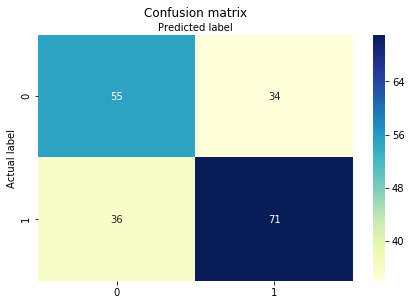

In [14]:
utils.display_confusion_matrix(y_test, y_pred)

In [15]:
prediction_probabilities = rf_classifier.predict_proba(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Log loss= ",log_loss(y_test, prediction_probabilities))

Accuracy: 0.6428571428571429
Precision: 0.6761904761904762
Recall: 0.6635514018691588
Log loss=  0.5995083026512474


In [16]:
cross_val_scores = cross_val_score(rf_classifier, X,y, cv=10, scoring='accuracy')
print("Baseline Cross Validation average= ",cross_val_scores.mean())

Baseline Cross Validation average=  0.7557121817799285


In [17]:
train_sizes, train_scores, test_scores = learning_curve(rf_classifier, 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

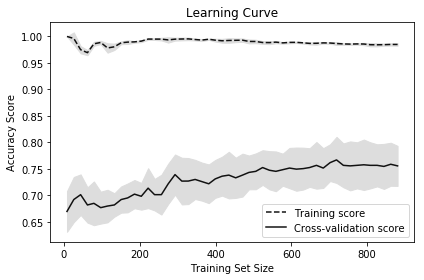

In [18]:
# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [ ]:
#param_grid = {
#    
#    "n_estimators": [500,750,1000,2000,3000],
#    "max_features":['sqrt'],
#    "criterion":['entropy'],
#    "min_samples_split": [2],
#    "min_samples_leaf":[2,5],
#    "max_depth": [10]
#}
#grid_search_model = GridSearchCV(estimator=RandomForestClassifier(), param_grid = param_grid, cv=5, 
#                                 n_jobs =-1, scoring='accuracy')

#grid_search_model.fit(X_train, y_train)
#score = grid_search_model.score(X_train, y_train)
#print("Grid Search  Model Score= ", score)


In [ ]:
#grid_search_model.best_params_

#### Model Feature Optimization

In [19]:
model_stats = eliminate_features(rf_classifier, X,y)

Iteration=  0
least_important label=  top_conf_t
Iteration=  1
least_important label=  top_conf_o
Iteration=  2
least_important label=  delta_def_rebs_avg
Iteration=  3
least_important label=  delta_off_rebs_avg
Iteration=  4
least_important label=  delta_to_net_avg
Iteration=  5
least_important label=  delta_ft_att_avg
Iteration=  6
least_important label=  delta_margin_victory_avg
Iteration=  7
least_important label=  delta_fg_pct
Iteration=  8
least_important label=  delta_ft_pct
Iteration=  9
least_important label=  delta_off_rating
Iteration=  10
least_important label=  delta_seed
Iteration=  11
least_important label=  delta_wol
Iteration=  12
least_important label=  delta_dol
Iteration=  13
least_important label=  delta_col
Iteration=  14
least_important label=  delta_mor
Iteration=  15
least_important label=  delta_wlk
Iteration=  16
least_important label=  delta_sag
Iteration=  17
least_important label=  delta_sos
Iteration=  18
least_important label=  delta_pom
Iteration=  19
l

In [20]:
max_accuracy = 0
max_cross_val = 0
min_log_loss = 10000
for key, value in model_stats.items():
    accuracy = value['accuracy']
    cross_val = value['cross_validation']
    log_loss_val = value['log_loss']
    print('Accuracy= {0:6.4f} Cross Val= {1:6.4f}  Log Loss= {2:6.4f}'.format(accuracy ,cross_val, log_loss_val ))
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        accuracy_hash = key
    if cross_val > max_cross_val:
        max_cross_val = cross_val
        cross_hash = key
    if log_loss_val < min_log_loss:
        min_log_loss = log_loss_val
        log_hash = key

print("\n")

print('Max Accuracy= {0:6.4f}'.format( model_stats[accuracy_hash]['accuracy']))
print('Max Cross Validation= {0:6.4f}'.format( model_stats[cross_hash]['cross_validation']))
print ("Minimum Log Loss= {0:6.4f}".format(  model_stats[log_hash]['log_loss']))
print('Log Loss at Max Accuracy= {0:6.4f}'.format( model_stats[accuracy_hash]['log_loss'] ))
print('Log Loss at Max Cross Validation= {0:6.4f} '.format( model_stats[cross_hash]['log_loss'] ))

Accuracy= 0.6429 Cross Val= 0.7557  Log Loss= 0.5995
Accuracy= 0.6582 Cross Val= 0.7588  Log Loss= 0.6025
Accuracy= 0.6531 Cross Val= 0.7578  Log Loss= 0.5988
Accuracy= 0.6633 Cross Val= 0.7669  Log Loss= 0.5979
Accuracy= 0.6837 Cross Val= 0.7628  Log Loss= 0.5984
Accuracy= 0.6735 Cross Val= 0.7659  Log Loss= 0.5972
Accuracy= 0.6888 Cross Val= 0.7649  Log Loss= 0.6006
Accuracy= 0.6735 Cross Val= 0.7639  Log Loss= 0.6033
Accuracy= 0.6786 Cross Val= 0.7669  Log Loss= 0.5971
Accuracy= 0.6786 Cross Val= 0.7751  Log Loss= 0.5975
Accuracy= 0.6735 Cross Val= 0.7771  Log Loss= 0.6041
Accuracy= 0.6837 Cross Val= 0.7751  Log Loss= 0.5996
Accuracy= 0.6684 Cross Val= 0.7771  Log Loss= 0.6006
Accuracy= 0.6786 Cross Val= 0.7771  Log Loss= 0.6028
Accuracy= 0.6990 Cross Val= 0.7771  Log Loss= 0.6050
Accuracy= 0.6786 Cross Val= 0.7751  Log Loss= 0.6157
Accuracy= 0.6786 Cross Val= 0.7812  Log Loss= 0.6235
Accuracy= 0.6939 Cross Val= 0.7750  Log Loss= 0.6138
Accuracy= 0.6684 Cross Val= 0.7464  Log Loss= 

In [21]:
model_features = model_stats[cross_hash]['labels']
print(model_features)

['delta_win_pct', 'delta_srs', 'delta_sos', 'delta_sag', 'delta_rth', 'delta_pom']


In [22]:
X=X[model_features]

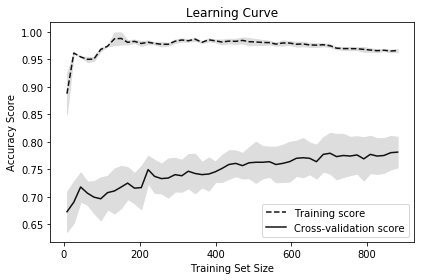

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 5)
rf_classifier.fit(X_train, y_train)



train_sizes, train_scores, test_scores = learning_curve(rf_classifier, 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))


train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

Accuracy: 0.6785714285714286
Precision: 0.7115384615384616
Recall: 0.6915887850467289
Log loss=  0.6235454700809201
Cross Validation:  0.7812329055333473


array([[59, 30],
       [33, 74]], dtype=int64)

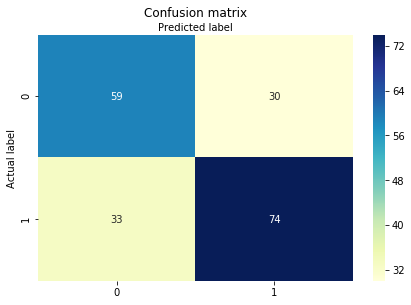

In [24]:
y_pred = rf_classifier.predict(X_test)
# save model stats
prediction_probabilities = rf_classifier.predict_proba(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Log loss= ",log_loss(y_test, prediction_probabilities))
cross_val_scores = cross_val_score(rf_classifier, X,y, cv=10, scoring='accuracy')
print("Cross Validation: ", cross_val_scores.mean())
utils.display_confusion_matrix(y_test, y_pred)

In [25]:
missed_predictions = get_missed_predictions(tourney_comp_ratings, model_features, prediction_probabilities, X_test, y_test, y_pred)
missed_predictions

                                       Kansas                   Bucknell     Stat Supports Winner
Allow PPG                       65.00                              58.00         True  (L)
FT %                            69.50                              70.10         True  (H)
Takeaway Avg                     6.00                               7.00         True  (H)
Seed                              3                                 14          False  (L)
SAG                              9.00                             114.00        False  (L)
WLK                              7.00                              97.00        False  (L)
WOL                             10.00                              84.00        False  (L)
RTH                              7.00                             137.00        False  (L)
COL                              4.00                             102.00        False  (L)
POM                             12.00                             110.00        Fal

                                         Duke                Connecticut     Stat Supports Winner
Allow PPG                       65.00                              63.00         True  (L)
Poss Avg                        81.84                              83.75         True  (H)
FG %                            47.10                              48.00         True  (H)
Off Rb Avg                      12.00                              15.00         True  (H)
Def Rb Avg                      23.00                              29.00         True  (H)
Margin Victory Avg              14.00                              15.00         True  (H)
Win %                           83.80                              84.60         True  (H)
Seed                              1                                  2          False  (L)
SAG                              1.00                               7.00        False  (L)
WLK                              2.00                               9.00        Fal

 Ohio State Wins.

Supporting Stat Count= 13  out of 25  stats.



                                     Kentucky                   Michigan     Stat Supports Winner
SOS                              9.90                               9.65         True  (H)
PPG                             74.00                              73.00         True  (H)
Poss Avg                        78.51                              70.12         True  (H)
Off Rb Avg                      14.00                               8.00         True  (H)
Def Rb Avg                      26.00                              22.00         True  (H)
FT ATT Avg                      28.00                              18.00         True  (H)
Seed                              8                                  2          False  (L)
SAG                             18.00                              10.00        False  (L)
WLK                             16.00                              13.00        False  (L)
WOL             

,season_t,round,game_date,seed_t,team_t,team_id_t,win_pts,seed_o,team_o,team_id_o,lose_pts,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf_t,top_conf_o,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_mor,predicted_result,pred_win_prob,supporting_features,supporting_model_features,features,model_features,game_index
128,2005,64,2005-03-18 00:00:00.0000000,3,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,64,14,Bucknell,98d2123a-c7b9-4b5f-8a81-43f76d8537dc,63,-1,2004,Lose,20.68,10.85,0.767,75.0,65.0,0.476,0.695,79.220000,11.0,25.0,14.0,6.0,94.673062,21.0,2.12,-2.19,0.697,63.0,58.0,0.444,0.701,71.569697,9.0,22.0,15.0,7.0,88.026082,20.0,Big 12,Patriot League,9,7.0,10,7,4.0,12.0,8.0,1.0,19,114,97.0,84,137,102.0,110.0,87.0,64.0,151,1,0,1,10.0,5.0,5.0,0.032,2.0,3.0,-0.006,8.0,8.0,0.0,0.070,6.646981,1.0,-11,18.56,13.04,-105,-90.0,-74,-130,-98.0,-98.0,-79.0,-132,1,0.994258,[ft_pct],[],4.545455,0.000000,128
512,2011,32,2011-03-20 00:00:00.0000000,3,Purdue,12d7f888-675b-459f-9099-a38f771d8a95,94,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,76,-1,2010,Lose,19.36,8.69,0.765,72.0,61.0,0.447,0.715,75.888235,11.0,24.0,10.0,6.0,94.876366,19.0,8.56,3.78,0.700,71.0,66.0,0.434,0.715,75.240000,10.0,21.0,11.0,8.0,94.364700,20.0,Big Ten,Atlantic 10,9,8.0,10,9,13.0,8.0,8.0,12.0,10,77,55.0,54,74,59.0,84.0,72.0,49.0,80,1,0,1,11.0,5.0,6.0,0.013,1.0,3.0,0.000,4.0,3.0,1.0,0.065,0.511667,-1.0,-8,10.80,4.91,-68,-47.0,-44,-65,-46.0,-76.0,-64.0,-70,1,0.991119,"[to_net_avg, ft_att_avg]",[],9.090909,0.000000,512
214,2006,8,2006-03-26 00:00:00.0000000,1,Connecticut,efba5350-79bc-47aa-a189-db177b95b491,86,11,George Mason,e76479d0-a768-46d2-89bf-7b9dae12bec8,84,-1,2005,Lose,21.22,6.57,0.882,81.0,67.0,0.473,0.706,86.076471,15.0,28.0,14.0,6.0,94.102371,25.0,12.11,2.77,0.771,69.0,60.0,0.481,0.664,73.440000,10.0,24.0,12.0,7.0,93.954248,18.0,American Athletic,Atlantic 10,2,2.0,2,2,3.0,2.0,2.0,3.0,2,38,25.0,37,53,45.0,28.0,43.0,26.0,75,1,0,1,14.0,9.0,5.0,-0.008,5.0,4.0,0.042,8.0,5.0,3.0,0.111,0.148123,7.0,-10,9.11,3.80,-36,-23.0,-35,-51,-42.0,-26.0,-41.0,-73,1,0.938536,"[fg_pct, to_net_avg]",[],9.090909,0.000000,214
178,2005,32,2005-03-19 00:00:00.0000000,2,Wake Forest,4fbebf0a-e117-4a0c-8f15-c247535a2a1b,111,7,West Virginia,f770d3a2-221c-49ce-9c7a-680f7417fe9e,105,-1,2004,Lose,20.24,10.27,0.818,84.0,73.0,0.491,0.684,85.224242,14.0,25.0,14.0,8.0,98.563504,27.0,11.76,7.62,0.686,71.0,67.0,0.450,0.742,73.782857,9.0,20.0,11.0,8.0,96.228315,17.0,Atlantic Coast,Big 12,4,4.0,3,4,6.0,5.0,3.0,7.0,5,38,39.0,28,32,34.0,35.0,30.0,34.0,30,0,0,0,11.0,4.0,7.0,0.041,5.0,5.0,-0.058,6.0,3.0,3.0,0.132,2.335190,10.0,-5,8.48,2.65,-34,-35.0,-25,-28,-28.0,-30.0,-27.0,-25,1,0.920871,"[ft_pct, to_net_avg]",[],9.090909,0.000000,178
852,2016,64,2016-03-18 00:00:00.0000000,3,West Virginia,f770d3a2-221c-49ce-9c7a-680f7417fe9e,70,14,Stephen F. Austin,5ef64f01-86ae-4553-9834-c79cc0859eaf,56,-1,2015,Lose,21.61,9.78,0.743,78.0,66.0,0.449,0.673,85.394286,15.0,23.0,14.0,9.0,91.341006,27.0,9.23,-5.47,0.824,80.0,63.0,0.478,0.735,80.100000,11.0,23.0,12.0,9.0,99.875156,20.0,Big 12,Southland,6,6.0,8,8,11.0,6.0,7.0,10.0,11,57,55.0,62,101,83.0,33.0,80.0,62.0,36,1,0,1,12.0,17.0,-5.0,-0.029,4.0,0.0,-0.062,5.0,3.0,2.0,-0.081,-8.534150,7.0,-11,12.38,15.25,-51,-49.0,-54,-93,-72.0,-2

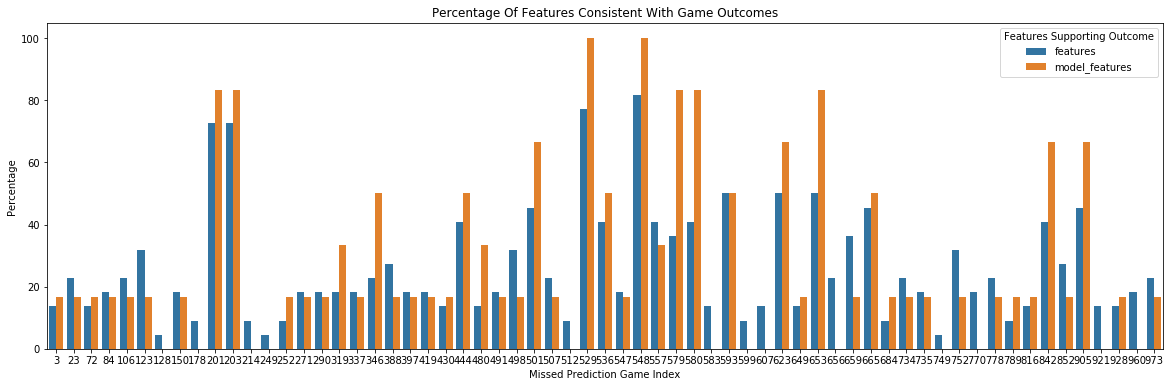

In [26]:
plot_missed_predictions_df = missed_predictions[['game_index','features','model_features']]
plot_missed_predictions_df = pd.melt(plot_missed_predictions_df, id_vars='game_index', var_name= 'Features Supporting Outcome')
m_plot = sns.barplot(x='game_index', y='value', hue='Features Supporting Outcome', data= plot_missed_predictions_df) 
plt.title("Percentage Of Features Consistent With Game Outcomes")
plt.ylabel('Percentage')
plt.xlabel('Missed Prediction Game Index')
m_plot.figure.set_size_inches(20,6)

#### The bar chart depicts the percentage of features that correctly corresponded to the game outcome but were out weighed by other features in predicting the game incorrectly. Games corresponding to bar heights exceeding 50% should be scrutinized.

### Run Model Against 2018 Tournament

In [27]:
test_year = 2018
X_season = feature_data[feature_data['season_t']== test_year][model_features]
y_season = tourney_comp_ratings[tourney_comp_ratings['season_t']== test_year]['game_result']
X_season.shape

(67, 6)

array([[23, 10],
       [ 9, 25]], dtype=int64)

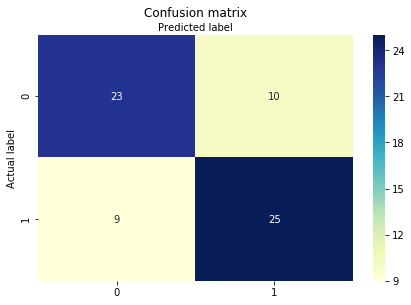

In [28]:
y_pred_season = rf_classifier.predict(X_season)
utils.display_confusion_matrix(y_season,y_pred_season)

In [29]:
prediction_probabilities = rf_classifier.predict_proba(X_season)
print("Accuracy:",metrics.accuracy_score(y_season, y_pred_season ))
print("Precision:",metrics.precision_score(y_season, y_pred_season ))
print("Recall:",metrics.recall_score(y_season, y_pred_season ))
print("Log loss= ",log_loss(y_season, prediction_probabilities))


Accuracy: 0.7164179104477612
Precision: 0.7142857142857143
Recall: 0.7352941176470589
Log loss=  0.6120045751176308
